In [159]:
# Load a recording and see all the information about it, used to troubleshoot

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from tools.data_formatting import get_smoothed_moving_all_data, get_tuning_curves, get_smoothed_moving_ca
from tools.data_manager import load_csv_data

In [161]:
animal = 'm70'
fov = 'fov1'
experiment = 'fam1nov'
run = 'fam1'
n_points = 72 # 72=360/5

firing_rates, time, phi, cells, average_firing_rates, phi_bins = get_smoothed_moving_all_data(animal, fov, experiment, run)
print(f'Firing rates: {firing_rates.shape}\ntime: {time.shape}\nphi: {phi.shape}\ncells: {cells.shape}\naverage firing rates: {average_firing_rates.shape}\nphi bins: {phi_bins.shape}')
tuning_curves, phi_bins = get_tuning_curves(firing_rates=firing_rates, phi=phi, n_points=n_points)

Firing rates: (5415, 85)
time: (5415,)
phi: (5415,)
cells: (85,)
average firing rates: (360, 85)
phi bins: (360,)


# Behaviour

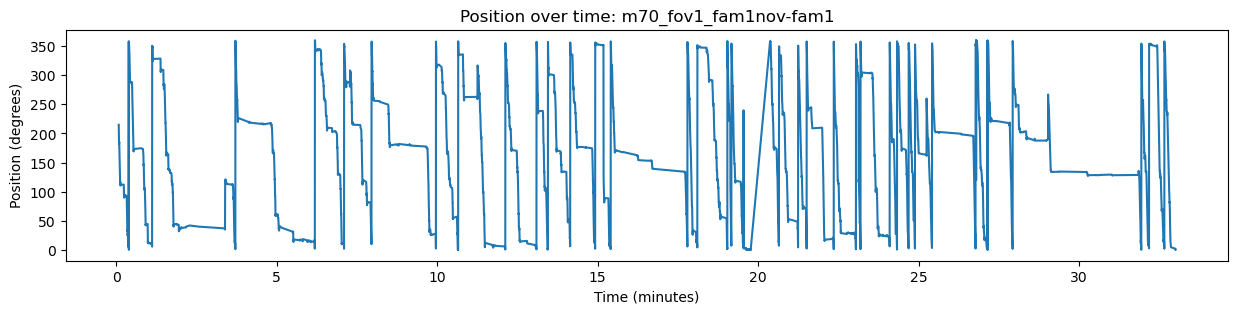

In [162]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(time/60, phi)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Position (degrees)')
ax.set_title(f'Position over time: {animal}_{fov}_{experiment}-{run}')
plt.show()

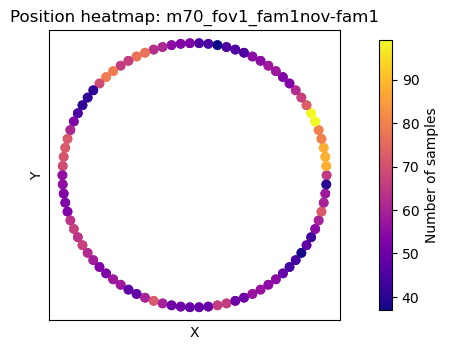

In [163]:
# Heat map of how well sampled is the position
n_points = 90
phi_mod = phi % 360
dphi = 360/n_points
bin_idx = np.floor(phi_mod / dphi).astype(int)
counts = np.zeros(n_points, dtype=int)
for i in range(len(phi_mod)):
    counts[bin_idx[i]] += 1
# Smooth the count to get a heatmap
smoothed_counts = medfilt(counts, kernel_size=3)
points_phi = (np.arange(n_points) * dphi) * np.pi / 180

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(np.cos(points_phi), np.sin(points_phi), c=smoothed_counts, cmap='plasma')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'Position heatmap: {animal}_{fov}_{experiment}-{run}')
# add colorbar
cbar = plt.colorbar(ax.scatter(np.cos(points_phi), np.sin(points_phi), c=smoothed_counts, cmap='plasma'), pad=0.1, shrink=0.7)
cbar.set_label('Number of samples')
ax.set_aspect('equal')
plt.show()

# Spikes

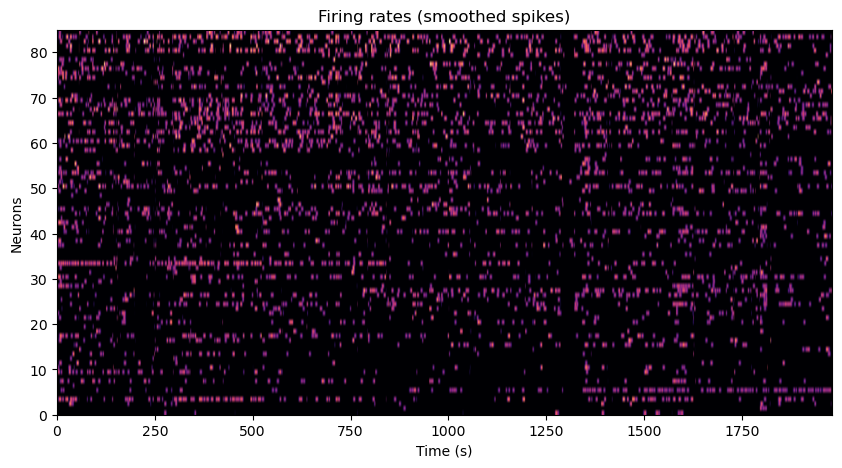

In [164]:
# Rasterplot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.imshow(np.sqrt(firing_rates).T, aspect='auto', cmap='magma', extent=[0, time[-1], 0, len(cells)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neurons')
ax.set_title('Firing rates (smoothed spikes)')
plt.show()

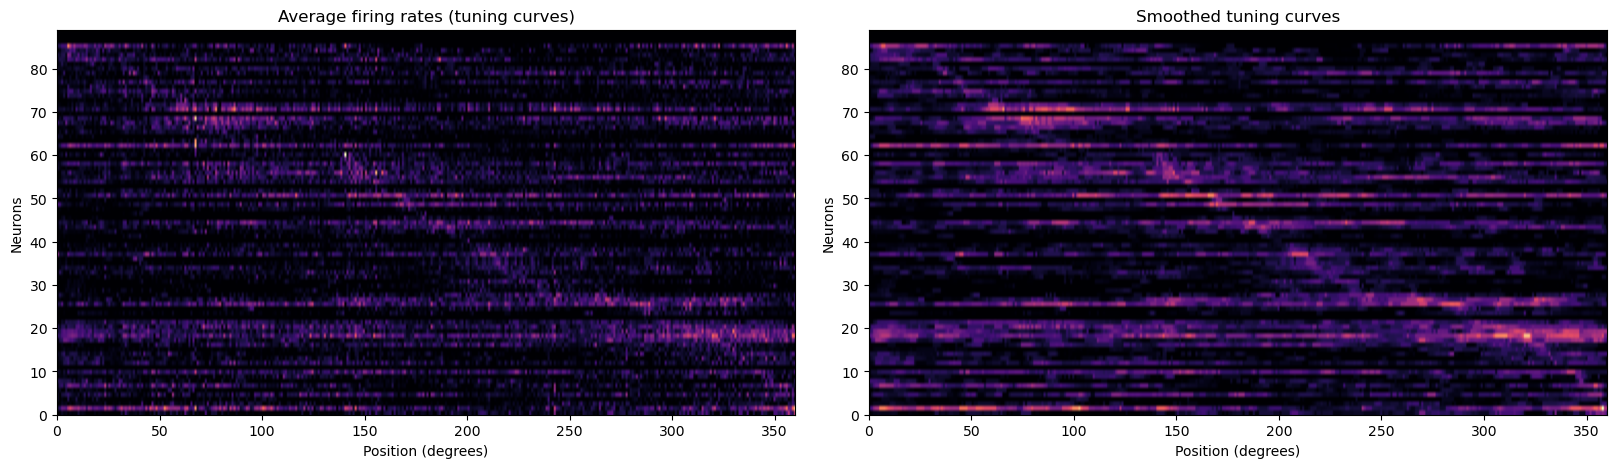

In [175]:
# Tuning curves
smoothed_avg_fr = medfilt(average_firing_rates, kernel_size=(5,1))
ordered_idxs = np.argsort(np.argmax(smoothed_avg_fr, axis=0))

fig = plt.figure(figsize=(20,5))
grid = plt.GridSpec(nrows=1, ncols=2, wspace=0.1)
ax = fig.add_subplot(grid[0, 0])
ax.imshow(average_firing_rates[:,ordered_idxs].T, aspect='auto', cmap='magma', extent=[0, 360, 0, len(cells)])
ax.set_xlabel('Position (degrees)')
ax.set_ylabel('Neurons')
ax.set_title('Average firing rates (tuning curves)')
ax = fig.add_subplot(grid[0, 1])
ax.imshow(smoothed_avg_fr[:,ordered_idxs].T, aspect='auto', cmap='magma', extent=[0, 360, 0, len(cells)])
ax.set_xlabel('Position (degrees)')
ax.set_ylabel('Neurons')
ax.set_title('Smoothed tuning curves')
plt.show()

# Firing rates manifolds

In [176]:
# Look at the manifold of the tuning curves
pca = PCA(n_components=3)
pca_tc = pca.fit_transform(average_firing_rates)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_tc[:,0], y=pca_tc[:,1], z=pca_tc[:,2], mode='markers', marker=dict(size=3, color=np.arange(pca_tc.shape[0]), colorscale='hsv')))
fig.update_layout(title='PCA of average firing rates', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
fig.show()

pca = PCA(n_components=3)
pca_tc_smoothed = pca.fit_transform(smoothed_avg_fr)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_tc_smoothed[:,0], y=pca_tc_smoothed[:,1], z=pca_tc_smoothed[:,2], mode='markers', marker=dict(size=3, color=np.arange(pca_tc_smoothed.shape[0]), colorscale='hsv')))
fig.update_layout(title='PCA of smoothed average firing rates', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
fig.show()


# Ca activity

In [167]:
ca, time, phi, cells = get_smoothed_moving_ca(animal, fov, experiment, run)
print(f'Ca: {ca.shape}\ntime: {time.shape}\nphi: {phi.shape}\ncells: {cells.shape}')

Ca: (15346, 89)
time: (15346,)
phi: (15346,)
cells: (89,)


Text(0.5, 1.0, 'Ca activity')

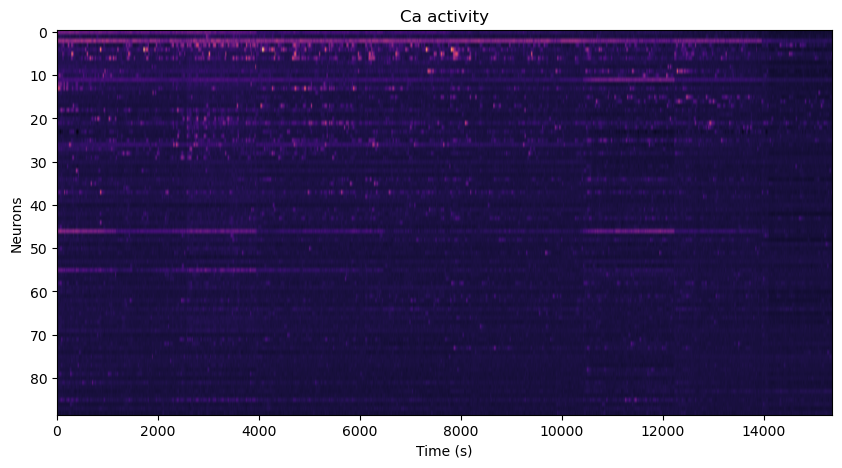

In [168]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.imshow(ca.T, aspect='auto', cmap='magma')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neurons')
ax.set_title('Ca activity')

/Users/elenafaillace/Documents/code/phd_in_progress/manifolds-remapping/tools/data_formatting.py:167: RuntimeWarning:

invalid value encountered in cast



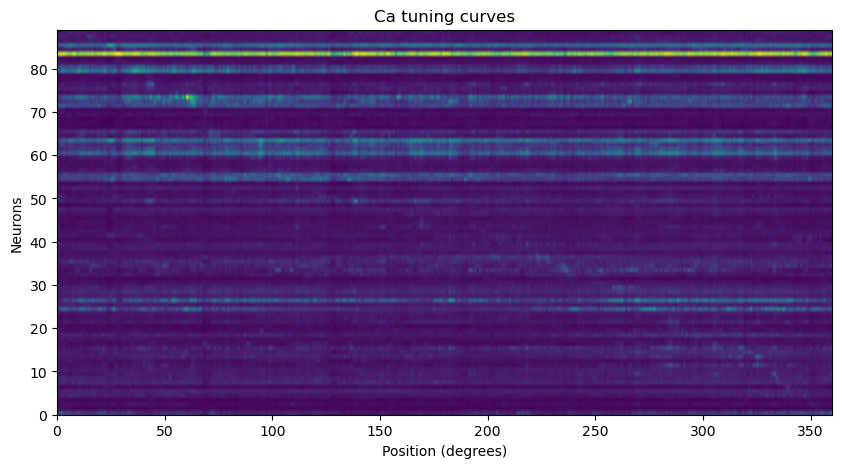

In [169]:
# Get tuning curves
ca_tuning_curves, phi_bins = get_tuning_curves(ca, phi, n_points=360)
smoothed_ca_tc = medfilt(ca_tuning_curves, kernel_size=(5,1))
ordered_idxs = np.argsort(np.argmax(ca_tuning_curves, axis=0))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.imshow(ca_tuning_curves[:,ordered_idxs].T, aspect='auto', extent=[0, 360, 0, len(cells)])
ax.set_xlabel('Position (degrees)')
ax.set_ylabel('Neurons')
ax.set_title('Ca tuning curves')
plt.show()

In [170]:
# PCA of the tuning curves
pca = PCA(n_components=3)
pca_ca_tc = pca.fit_transform(ca_tuning_curves)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_ca_tc[:,0], y=pca_ca_tc[:,1], z=pca_ca_tc[:,2], mode='markers', marker=dict(size=3, color=np.arange(pca_ca_tc.shape[0]), colorscale='hsv')))
fig.update_layout(title='PCA of Ca tuning curves', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
fig.show()

pca = PCA(n_components=3)
pca_ca_tc_smoothed = pca.fit_transform(smoothed_ca_tc)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pca_ca_tc_smoothed[:,0], y=pca_ca_tc_smoothed[:,1], z=pca_ca_tc_smoothed[:,2], mode='markers', marker=dict(size=3, color=np.arange(pca_ca_tc_smoothed.shape[0]), colorscale='hsv')))
fig.update_layout(title='PCA of smoothed Ca tuning curves', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
fig.show()